In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import matplotlib.pyplot as plt



In [5]:
import pandas as pd

df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/recovered_long_cleaned.csv")

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Find the last date where Recovered is not zero
last_valid_date = df[df['Recovered'] > 0]['Date'].max()
print("Last valid date with recovered data:", last_valid_date)

# Filter the DataFrame to only include data up to this date
filtered_df = df[df['Date'] <= last_valid_date].copy()

# Now you can use filtered_df for training your model


Last valid date with recovered data: 2021-08-04 00:00:00


In [ ]:
df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/recovered_long_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Find the last date with a nonzero recovered value for each country
last_valid_dates = (
    df[df['Recovered'] > 0]
    .groupby('Country/Region')['Date']
    .max()
    .reset_index()
    .rename(columns={'Date': 'Last_Valid_Date'})
)


In [9]:
# Merge to get each row's country's last valid date
df = df.merge(last_valid_dates, on='Country/Region', how='left')

# Keep only rows up to the last valid date for each country
filtered_df = df[df['Date'] <= df['Last_Valid_Date']].copy()


  0%|          | 0/191 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
  1%|          | 1/191 [00:30<1:36:37, 30.51s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
  1%|          | 2/191 [00:57<1:30:00, 28.58s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential m

✅ Saved: daily_to_cumulative_predictions.csv


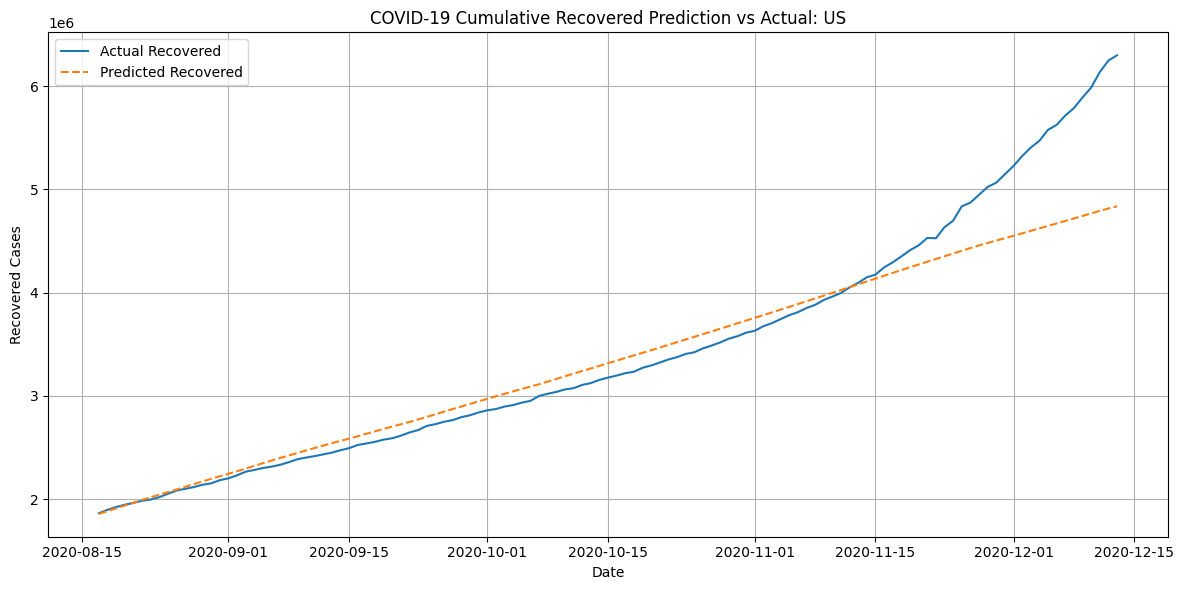

In [10]:
df = filtered_df
df.sort_values(['Country/Region', 'Date'], inplace=True)

# Compute daily cases instead of cumulative
df['Daily_Recovered'] = df.groupby('Country/Region')['Recovered'].diff().fillna(0)

# Store predictions
all_predictions = []

# Function to create LSTM input sequences
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Loop through each country
countries = df['Country/Region'].unique()

for country in tqdm(countries):
    country_df = df[df['Country/Region'] == country]
    daily_cases = country_df[['Daily_Recovered']].values

    if len(daily_cases) < 40:
        continue

    scaler = MinMaxScaler()
    daily_scaled = scaler.fit_transform(daily_cases)

    # Create sequences
    X, y = create_sequences(daily_scaled, window=30)
    if len(X) == 0:
        continue

    split = int(len(X) * 0.6)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model
    model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(30, 1)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
     ])
  
    model.compile(optimizer=Adam(learning_rate= 0.001), loss='huber')
    
    callbacks = [
    EarlyStopping(patience=15),
    ReduceLROnPlateau(factor=0.2, patience=5)
    ]
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    
    
    # Predict daily cases on test
    y_pred = model.predict(X_test, verbose=0)
    y_pred_actual = scaler.inverse_transform(y_pred).flatten()
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Reconstruct predicted cumulative cases
    start_cumulative = country_df['Recovered'].iloc[-len(y_test_actual)-1]
    predicted_cumulative = np.cumsum(y_pred_actual) + start_cumulative
    actual_cumulative = country_df['Recovered'].iloc[-len(y_test_actual):].values

    test_dates = country_df['Date'].iloc[-len(y_test_actual):].values

    for date, actual, predicted in zip(test_dates, actual_cumulative, predicted_cumulative):
        all_predictions.append({
            'Country/Region': country,
            'Date': date,
            'Actual_Recovered': actual,
            'Predicted_Recovered': predicted
        })

# Save all predictions to CSV
final_df = pd.DataFrame(all_predictions)
final_df.to_csv("/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions_recovered.csv", index=False)
print("✅ Saved: daily_to_cumulative_predictions.csv")

# --- OPTIONAL: Plot for one country ---
plot_country = "US"  # change to any country like 'India', 'Italy', etc.
country_plot_df = final_df[final_df['Country/Region'] == plot_country]

plt.figure(figsize=(12, 6))
plt.plot(country_plot_df['Date'], country_plot_df['Actual_Recovered'], label='Actual Recovered')
plt.plot(country_plot_df['Date'], country_plot_df['Predicted_Recovered'], label='Predicted Recovered', linestyle='--')
plt.title(f"COVID-19 Cumulative Recovered Prediction vs Actual: {plot_country}")
plt.xlabel("Date")
plt.ylabel("Recovered Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


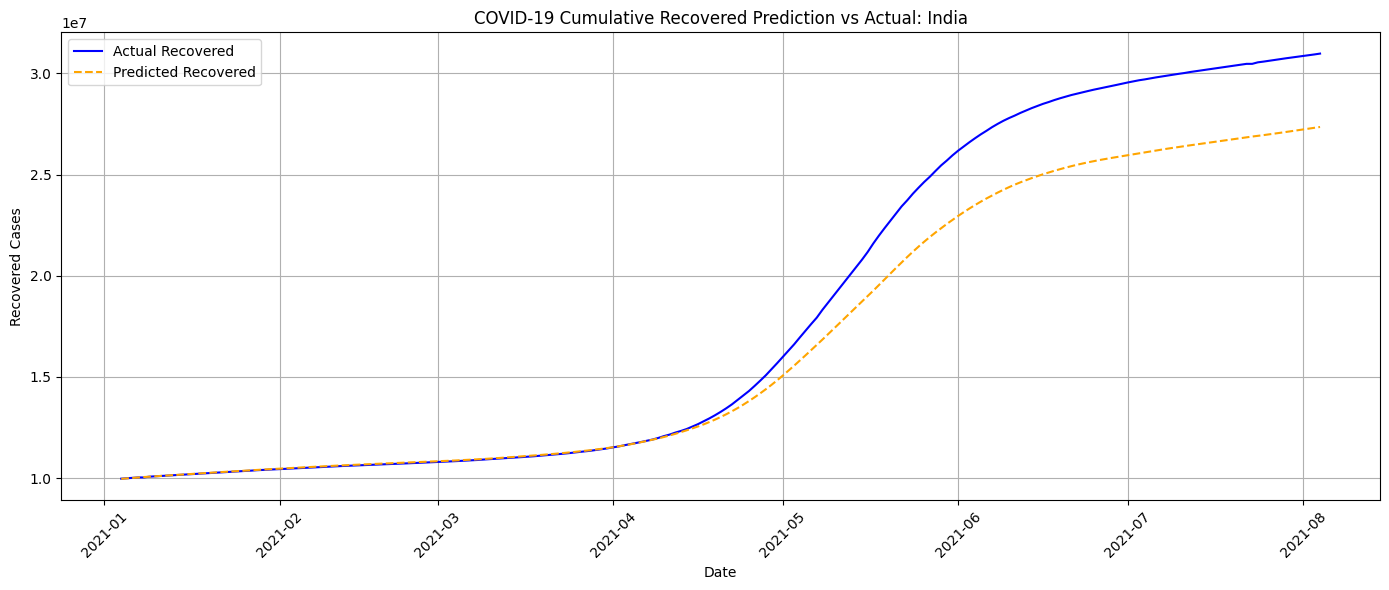

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess the data
final_df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions_recovered.csv")

# ✅ Convert 'Date' to datetime for proper x-axis formatting
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Filter data for a specific country
plot_country = "India"
country_plot_df = final_df[final_df['Country/Region'] == plot_country]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(country_plot_df['Date'], country_plot_df['Actual_Recovered'], label='Actual Recovered', color='blue')
plt.plot(country_plot_df['Date'], country_plot_df['Predicted_Recovered'], label='Predicted Recovered', linestyle='--', color='orange')
plt.title(f"COVID-19 Cumulative Recovered Prediction vs Actual: {plot_country}")
plt.xlabel("Date")
plt.ylabel("Recovered Cases")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


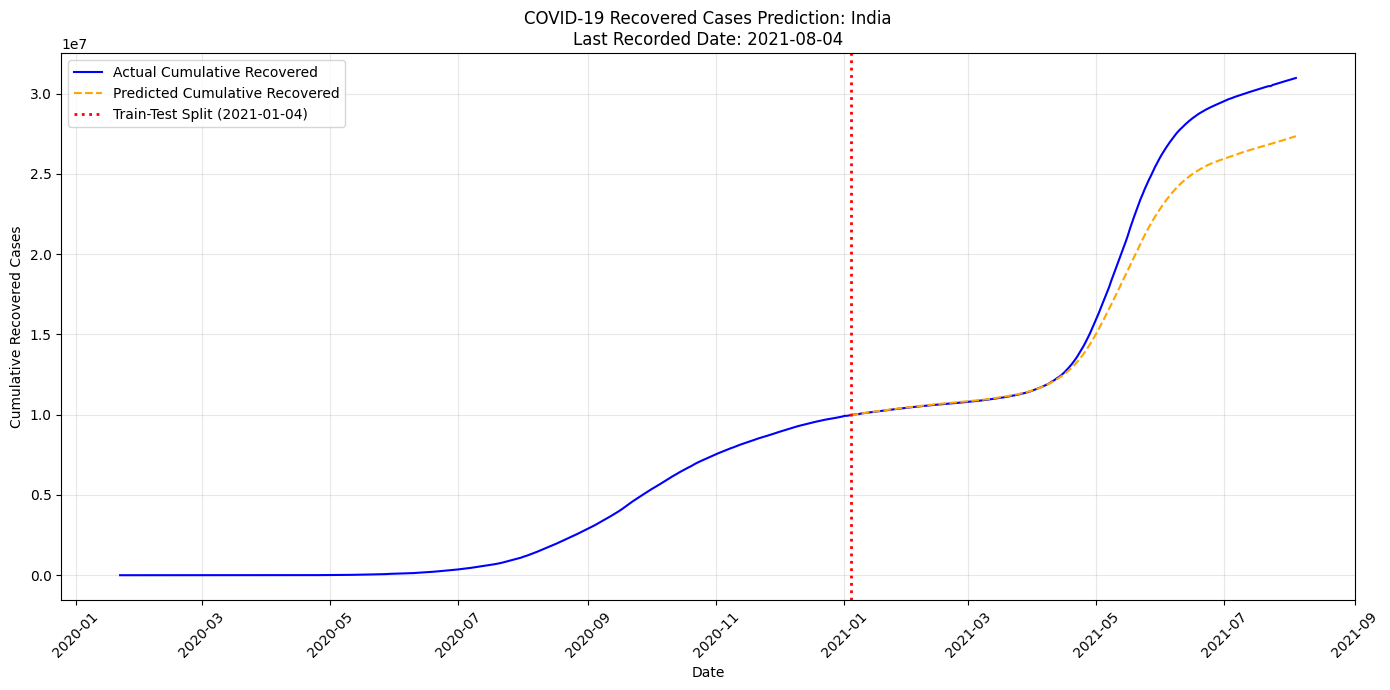

In [16]:
# --- Plot for one country ---
plot_country = "India"  # Change to desired country

# Load original filtered data for the country
country_actual_df = filtered_df[filtered_df['Country/Region'] == plot_country]

# Load predictions
country_pred_df = final_df[final_df['Country/Region'] == plot_country]

if not country_actual_df.empty and not country_pred_df.empty:
    plt.figure(figsize=(14, 7))
    
    # 1. Plot full actual data
    plt.plot(country_actual_df['Date'], 
             country_actual_df['Recovered'], 
             label='Actual Cumulative Recovered',
             color='blue')
    
    # 2. Plot predicted cumulative data
    plt.plot(country_pred_df['Date'], 
             country_pred_df['Predicted_Recovered'], 
             label='Predicted Cumulative Recovered',
             linestyle='--',
             color='orange')
    
    # 3. Add vertical train-test split line
    split_date = country_pred_df['Date'].min()
    plt.axvline(x=split_date, 
                color='red', 
                linestyle=':', 
                linewidth=2,
                label=f'Train-Test Split ({split_date.strftime("%Y-%m-%d")})')
    
    # 4. Formatting
    plt.title(f'COVID-19 Recovered Cases Prediction: {plot_country}\n'
              f'Last Recorded Date: {country_actual_df["Date"].max().strftime("%Y-%m-%d")}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Recovered Cases')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"Insufficient data for {plot_country}")


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define file paths
cumulative_path = "/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions_recovered.csv"

# Check if file exists
if not os.path.exists(cumulative_path):
    print(f"❌ Error: File not found at {cumulative_path}")
    print("Please make sure you've run your prediction code and saved the results.")
    # If file doesn't exist, we can't proceed with that specific file
else:
    # Load cumulative predictions
    cumulative_predictions = pd.read_csv(cumulative_path)
    
    # Ensure the Date column is in datetime format
    cumulative_predictions['Date'] = pd.to_datetime(cumulative_predictions['Date'])
    
    # Sort by Country/Region and Date to ensure proper order
    cumulative_predictions.sort_values(['Country/Region', 'Date'], inplace=True)
    
    # Calculate daily recovered cases from cumulative predictions
    cumulative_predictions['Actual_Daily_Recovered'] = cumulative_predictions.groupby('Country/Region')['Actual_Recovered'].diff().fillna(0)
    cumulative_predictions['Predicted_Daily_Recovered'] = cumulative_predictions.groupby('Country/Region')['Predicted_Recovered'].diff().fillna(0)
    
    # Save the updated DataFrame with daily recovered cases
    output_path = "/Users/jayanthmanthrigalla/Downloads/daily_recovered_from_predictions.csv"
    cumulative_predictions.to_csv(output_path, index=False)
    print(f"✅ Daily recovered cases from predictions saved to: {output_path}")


✅ Daily recovered cases from predictions saved to: /Users/jayanthmanthrigalla/Downloads/daily_recovered_from_predictions.csv


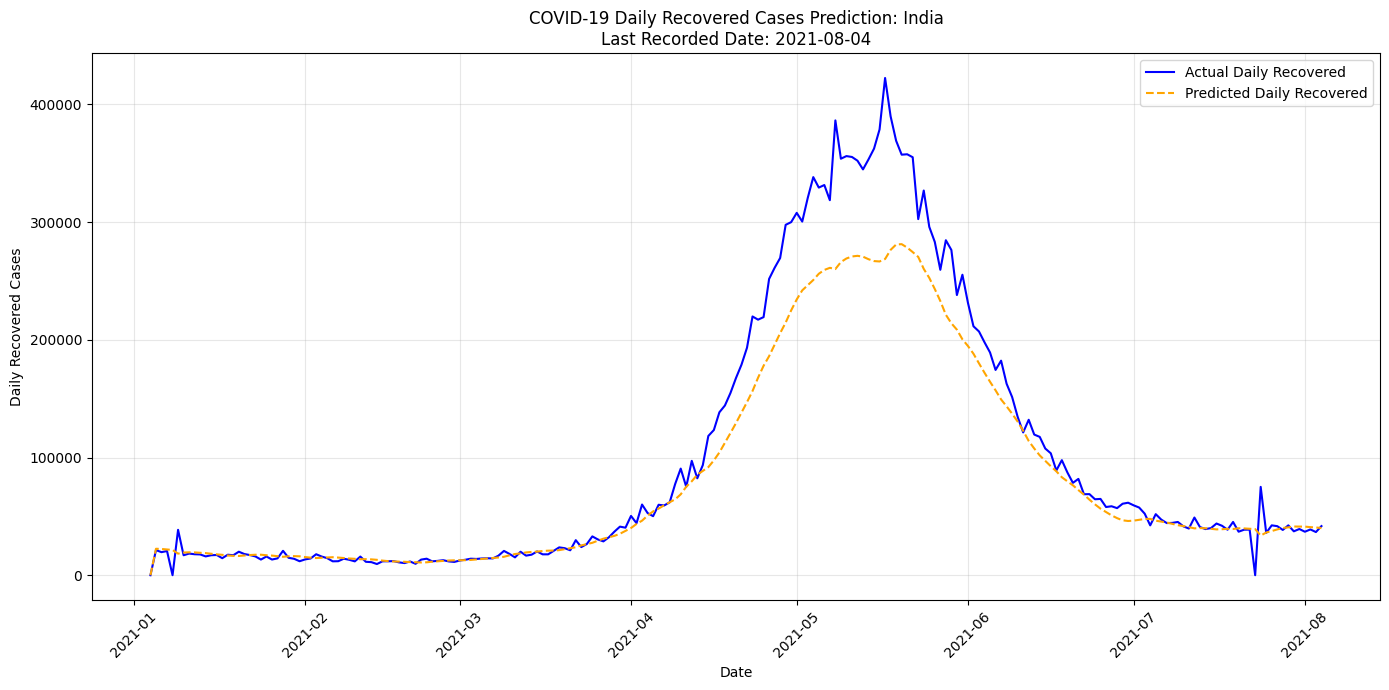

In [ ]:
def plot_daily_recovered(country="India"):
    """
    Create a plot of daily recovered cases (actual vs predicted) for a specific country.
    
    Parameters:
    country (str): Country name to plot data for
    """
    try:
        # Load the data (if file exists; if not, try using the original cumulative data)
        try:
            df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/daily_recovered_from_predictions.csv")
            df['Date'] = pd.to_datetime(df['Date'])
        except FileNotFoundError:
            print("Daily recovered file not found. Processing from cumulative data...")
            df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions_recovered.csv")
            df['Date'] = pd.to_datetime(df['Date'])
            df.sort_values(['Country/Region', 'Date'], inplace=True)
            df['Actual_Daily_Recovered'] = df.groupby('Country/Region')['Actual_Recovered'].diff().fillna(0)
            df['Predicted_Daily_Recovered'] = df.groupby('Country/Region')['Predicted_Recovered'].diff().fillna(0)
            
        
        # Filter for the specified country
        country_df = df[df['Country/Region'] == country]
        
        if country_df.empty:
            print(f"No data found for {country}")
            return
            
        # Get the last recorded date for this country
        last_date = country_df['Date'].max().strftime('%Y-%m-%d')
        
        # Get the train-test split date (first date of predictions)
        split_date = country_df['Date'].min()
        
        plt.figure(figsize=(14, 7))
        
        # Plot actual daily recovered
        plt.plot(country_df['Date'], 
                country_df['Actual_Daily_Recovered'], 
                label='Actual Daily Recovered',
                color='blue')
        
        # Plot predicted daily recovered
        plt.plot(country_df['Date'], 
                country_df['Predicted_Daily_Recovered'], 
                label='Predicted Daily Recovered',
                linestyle='--',
                color='orange')
        
        
        
        # Add labels and formatting
        plt.title(f'COVID-19 Daily Recovered Cases Prediction: {country}\n'
                 f'Last Recorded Date: {last_date}')
        plt.xlabel('Date')
        plt.ylabel('Daily Recovered Cases')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating plot: {e}")

# Generate plot for India
plot_daily_recovered("India")


In [26]:
import pandas as pd
import numpy as np

# Load cumulative predictions
cumulative_path = "/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions_recovered.csv"

# Load cumulative predictions
cumulative_predictions = pd.read_csv(cumulative_path)
cumulative_predictions['Date'] = pd.to_datetime(cumulative_predictions['Date'])

# Sort by Country/Region and Date to ensure proper order
cumulative_predictions.sort_values(['Country/Region', 'Date'], inplace=True)

# Calculate daily recovered cases from cumulative predictions
cumulative_predictions['Actual_Daily_Recovered'] = cumulative_predictions.groupby('Country/Region')['Actual_Recovered'].diff().fillna(0)
cumulative_predictions['Predicted_Daily_Recovered'] = cumulative_predictions.groupby('Country/Region')['Predicted_Recovered'].diff().fillna(0)

# Save the updated DataFrame with daily recovered cases
output_path = "/Users/jayanthmanthrigalla/Downloads/daily_recovered_from_predictions.csv"
cumulative_predictions.to_csv(output_path, index=False)
print(f"✅ Daily recovered cases from predictions saved to: {output_path}")


✅ Daily recovered cases from predictions saved to: /Users/jayanthmanthrigalla/Downloads/daily_recovered_from_predictions.csv


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize a dictionary to store metrics for each country
metrics = []

# Loop through each country
for country in cumulative_predictions['Country/Region'].unique():
    country_data = cumulative_predictions[cumulative_predictions['Country/Region'] == country]
    
    # Extract actual and predicted daily recovered cases
    actual = country_data['Actual_Daily_Recovered'].values
    predicted = country_data['Predicted_Daily_Recovered'].values
    
    # Skip countries with insufficient data
    if len(actual) < 2:
        continue
        
    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    r2 = r2_score(actual, predicted)
    
    # Append metrics to the list
    metrics.append({
        'Country/Region': country,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Display metrics sorted by MAE (ascending)
sorted_metrics = metrics_df.sort_values('MAE')
print(sorted_metrics.head(10))  # Top 10 countries with lowest MAE

# Save metrics to CSV
metrics_df.to_csv("/Users/jayanthmanthrigalla/Downloads/recovery_prediction_metrics.csv", index=False)


       Country/Region       MAE       MSE      RMSE        R²
104        MS Zaandam  0.004781  0.000023  0.004792  0.000000
115        Micronesia  0.004816  0.004695  0.068520 -0.004745
184           Vanuatu  0.011160  0.018748  0.136924 -0.003054
147             Samoa  0.014077  0.004696  0.068525 -0.004883
111  Marshall Islands  0.016662  0.000279  0.016702  0.000000
158   Solomon Islands  0.106984  0.251995  0.501991 -0.074711
75           Holy See  0.112859  0.672713  0.820191  0.000251
170          Tanzania  0.171902  0.029690  0.172307  0.000000
50           Dominica  0.829285  3.573229  1.890299 -0.116856
69            Grenada  0.947193  4.638609  2.153743 -1.443729


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Extract actual and predicted daily cases
actual_daily = country_data['Actual_Recovered'].values
predicted_daily = country_data['Predicted_Recovered'].values

# Calculate metrics
mae = mean_absolute_error(actual_daily, predicted_daily)
mse = mean_squared_error(actual_daily, predicted_daily)
r2 = r2_score(actual_daily, predicted_daily)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 11939.02
MSE: 209246043.47
R²: -0.3373


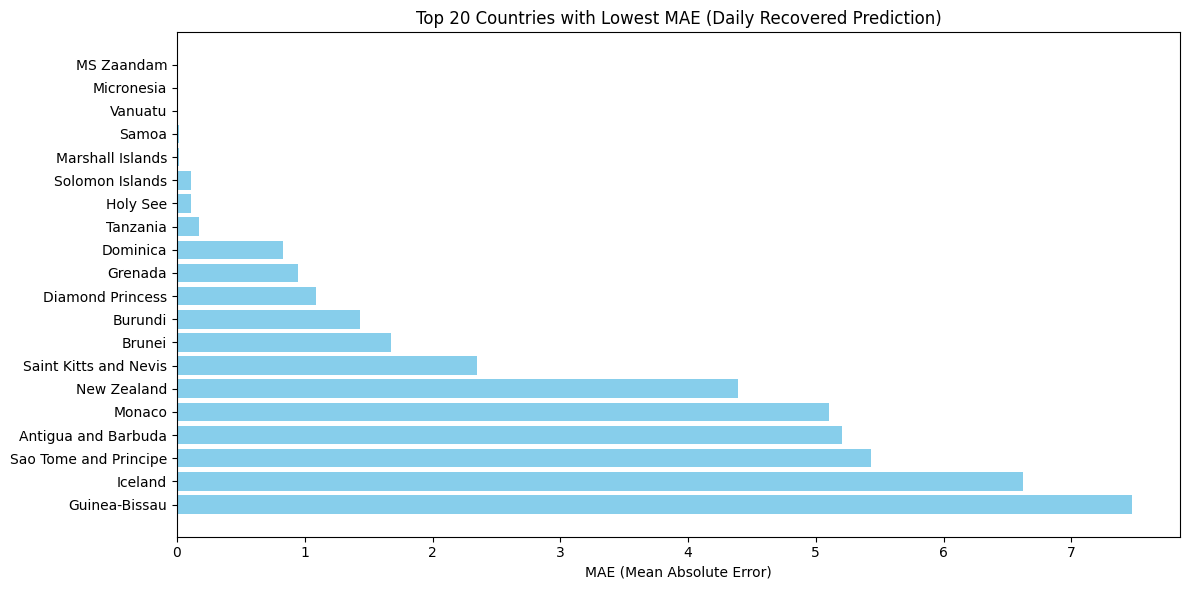

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics DataFrame
metrics_df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/recovery_prediction_metrics.csv")

# Sort by MAE (ascending) and select top 20
top_mae = metrics_df.sort_values('MAE').head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_mae['Country/Region'], top_mae['MAE'], color='skyblue')
plt.xlabel('MAE (Mean Absolute Error)')
plt.title('Top 20 Countries with Lowest MAE (Daily Recovered Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


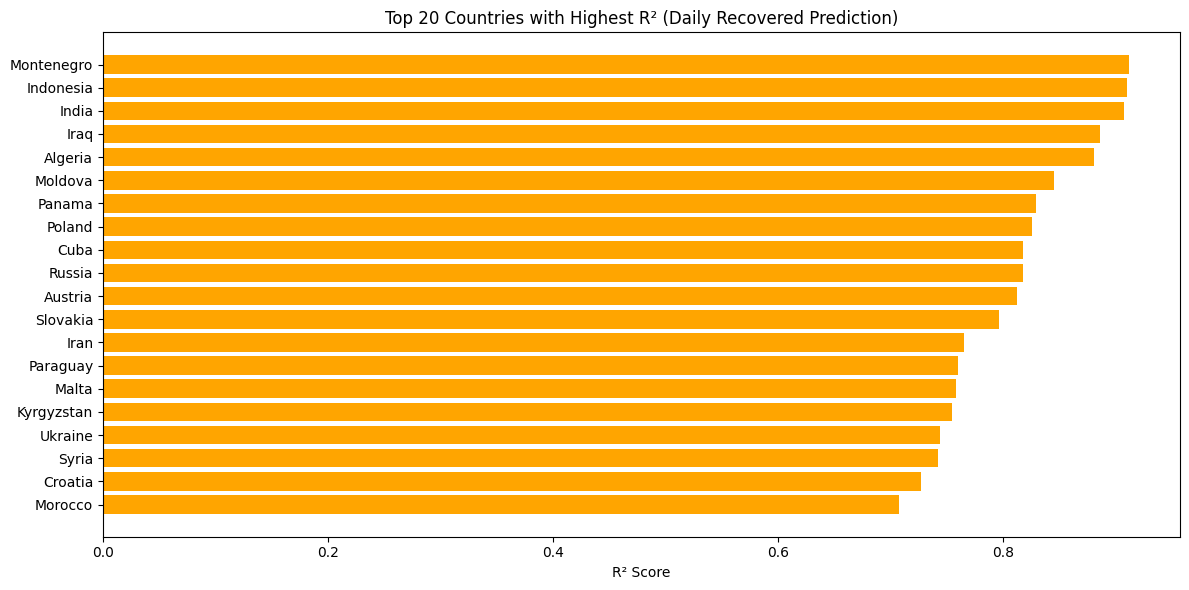

In [34]:
# Sort by R2 (descending) and select top 20
top_r2 = metrics_df.sort_values('R²', ascending=False).head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_r2['Country/Region'], top_r2['R²'], color='orange')
plt.xlabel('R² Score')
plt.title('Top 20 Countries with Highest R² (Daily Recovered Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


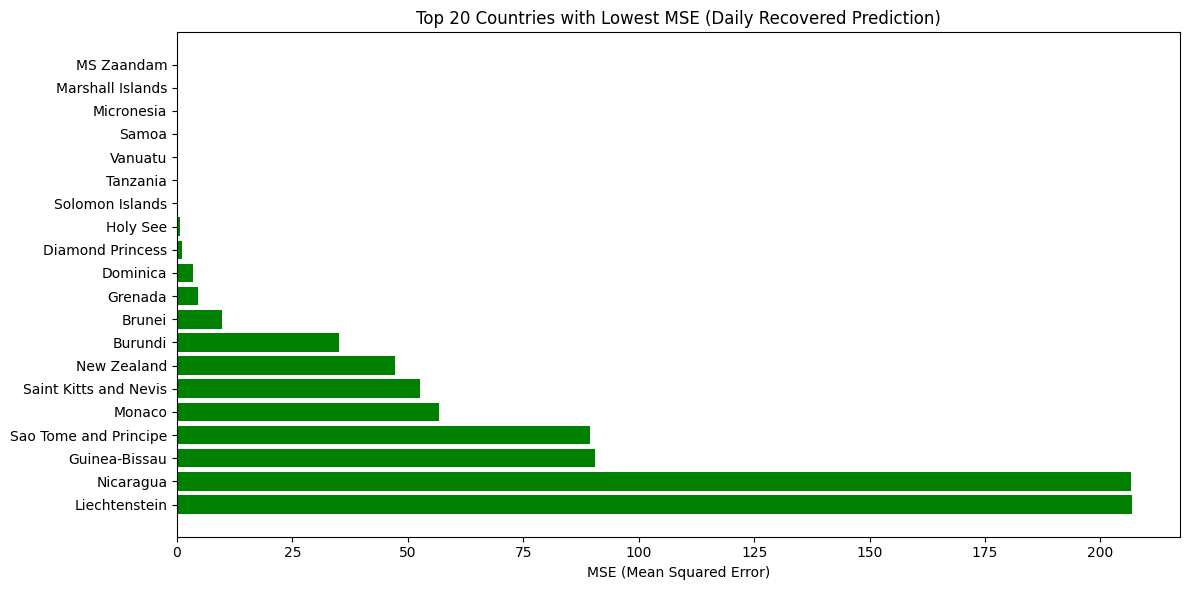

In [35]:
# Sort by MSE (ascending) and select top 20
top_mse = metrics_df.sort_values('MSE').head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_mse['Country/Region'], top_mse['MSE'], color='green')
plt.xlabel('MSE (Mean Squared Error)')
plt.title('Top 20 Countries with Lowest MSE (Daily Recovered Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [10]:
metrics_df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/recovery_prediction_metrics.csv")

metrics_df = metrics_df [['Country/Region', 'MAE', 'MSE', 'R²']]

metrics_df

Country/Region         MAE            MSE        R²
0           Afghanistan  174.084745   91366.666942 -0.205539
1               Albania  245.546563  129243.768900 -0.054917
2               Algeria   38.589654    4118.189999  0.881055
3               Andorra   21.136143     991.845346  0.000056
4                Angola  102.534831   27309.111685  0.130476
..                  ...         ...            ...       ...
186             Vietnam  242.167508  790599.164410 -0.028238
187  West Bank and Gaza  277.385306  203808.433092  0.647799
188               Yemen   12.136347     393.189791 -0.170532
189              Zambia  601.069432  805201.414752 -0.141041
190            Zimbabwe  263.831710  277071.697435  0.060177

[191 rows x 4 columns]